In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-01 15:51:00.006613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 15:51:00.006772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="gauss", threshold=0.5,
                                  noise_distribution="gauss", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:100096, :], y[:100096]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(30, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/41


2022-05-01 15:51:02.879190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 15:51:02.879247: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 15:51:02.879278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-01 15:51:02.883107: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


391/391 [==============================] - 2s 3ms/step - loss: 0.6831 - accuracy: 0.5637 - auc: 0.5873 - val_loss: 0.6578 - val_accuracy: 0.6903 - val_auc: 0.7702
Epoch 2/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6362 - auc: 0.6875 - val_loss: 0.6163 - val_accuracy: 0.7799 - val_auc: 0.8642
Epoch 3/41
391/391 [==============================] - 1s 3ms/step - loss: 0.6131 - accuracy: 0.6955 - auc: 0.7629 - val_loss: 0.5633 - val_accuracy: 0.8248 - val_auc: 0.9114
Epoch 4/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5651 - accuracy: 0.7439 - auc: 0.8218 - val_loss: 0.4995 - val_accuracy: 0.8594 - val_auc: 0.9408
Epoch 5/41
391/391 [==============================] - 1s 3ms/step - loss: 0.5113 - accuracy: 0.7817 - auc: 0.8636 - val_loss: 0.4317 - val_accuracy: 0.8850 - val_auc: 0.9593
Epoch 6/41
391/391 [==============================] - 2s 4ms/step - loss: 0.4565 - accuracy: 0.8121 - auc: 0.8942 - val_loss: 0.3662 - val_ac

391/391 [==============================] - 1s 2ms/step - loss: 0.2042 - accuracy: 0.9154 - auc: 0.9746 - val_loss: 0.1016 - val_accuracy: 0.9683 - val_auc: 0.9967
Epoch 10/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1924 - accuracy: 0.9214 - auc: 0.9774 - val_loss: 0.0944 - val_accuracy: 0.9707 - val_auc: 0.9972
Epoch 11/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1818 - accuracy: 0.9248 - auc: 0.9799 - val_loss: 0.0877 - val_accuracy: 0.9726 - val_auc: 0.9976
Epoch 12/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1700 - accuracy: 0.9297 - auc: 0.9824 - val_loss: 0.0819 - val_accuracy: 0.9753 - val_auc: 0.9979
Epoch 13/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1626 - accuracy: 0.9334 - auc: 0.9838 - val_loss: 0.0768 - val_accuracy: 0.9775 - val_auc: 0.9982
Epoch 14/41
391/391 [==============================] - 1s 2ms/step - loss: 0.1562 - accuracy: 0.9364 - auc: 0.9850 - val_loss: 0.0725 - v

Epoch 60/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0294 - accuracy: 0.9894 - auc: 0.9996 - val_loss: 0.0121 - val_accuracy: 0.9976 - val_auc: 1.0000
Epoch 61/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0285 - accuracy: 0.9895 - auc: 0.9996 - val_loss: 0.0120 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 62/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0287 - accuracy: 0.9896 - auc: 0.9996 - val_loss: 0.0118 - val_accuracy: 0.9974 - val_auc: 1.0000
Epoch 63/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0278 - accuracy: 0.9903 - auc: 0.9996 - val_loss: 0.0115 - val_accuracy: 0.9979 - val_auc: 1.0000
Epoch 64/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0270 - accuracy: 0.9904 - auc: 0.9996 - val_loss: 0.0114 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 65/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0268 - accuracy: 0.9904 - auc: 0.9996 - val_loss

Epoch 68/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0211 - accuracy: 0.9924 - auc: 0.9998 - val_loss: 0.0096 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 69/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0206 - accuracy: 0.9929 - auc: 0.9998 - val_loss: 0.0095 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 70/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0208 - accuracy: 0.9927 - auc: 0.9998 - val_loss: 0.0093 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 71/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0203 - accuracy: 0.9931 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 72/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0196 - accuracy: 0.9933 - auc: 0.9998 - val_loss: 0.0092 - val_accuracy: 0.9978 - val_auc: 1.0000
Epoch 73/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9935 - auc: 0.9998 - val_loss

Epoch 76/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0160 - accuracy: 0.9946 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 77/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0163 - accuracy: 0.9943 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 78/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 0.9940 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 79/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.9945 - auc: 0.9999 - val_loss: 0.0073 - val_accuracy: 0.9981 - val_auc: 1.0000
Epoch 80/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0156 - accuracy: 0.9942 - auc: 0.9999 - val_loss: 0.0071 - val_accuracy: 0.9980 - val_auc: 1.0000
Epoch 81/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9948 - auc: 0.9999 - val_loss

Epoch 2/3
12512/12512 [==============================] - 30s 2ms/step - loss: 0.0305 - accuracy: 0.9883 - auc: 0.9992 - val_loss: 0.0170 - val_accuracy: 0.9917 - val_auc: 0.9997
Epoch 3/3
12512/12512 [==============================] - 38s 3ms/step - loss: 0.0282 - accuracy: 0.9887 - auc: 0.9992 - val_loss: 0.0160 - val_accuracy: 0.9933 - val_auc: 0.9999
{'learning_rate': 0.0036, 'batch': 8, 'epoch': 1, 'optimizer': 'adam', 'best_loss': {'loss': 0.016002438962459564, 'epoch': 3}, 'best_auc': {'auc': 0.9998602867126465, 'epoch': 3}, 'best_accuracy': {'accuracy': 0.9932500123977661, 'epoch': 3}}
Epoch 1/4
12512/12512 [==============================] - 22s 2ms/step - loss: 0.3327 - accuracy: 0.8429 - auc: 0.9317 - val_loss: 0.0772 - val_accuracy: 0.9756 - val_auc: 0.9983
Epoch 2/4
12512/12512 [==============================] - 22s 2ms/step - loss: 0.1424 - accuracy: 0.9419 - auc: 0.9874 - val_loss: 0.0436 - val_accuracy: 0.9863 - val_auc: 0.9995
Epoch 3/4
12512/12512 [=====================

Epoch 6/7
12512/12512 [==============================] - 28s 2ms/step - loss: 0.0300 - accuracy: 0.9888 - auc: 0.9991 - val_loss: 0.0249 - val_accuracy: 0.9918 - val_auc: 0.9991
Epoch 7/7
12512/12512 [==============================] - 42s 3ms/step - loss: 0.0291 - accuracy: 0.9892 - auc: 0.9990 - val_loss: 0.0229 - val_accuracy: 0.9915 - val_auc: 0.9994
{'learning_rate': 0.007, 'batch': 8, 'epoch': 4, 'optimizer': 'nadam', 'best_loss': {'loss': 0.016949178650975227, 'epoch': 5}, 'best_auc': {'auc': 0.99990314245224, 'epoch': 4}, 'best_accuracy': {'accuracy': 0.9944499731063843, 'epoch': 4}}
Epoch 1/7
12512/12512 [==============================] - 24s 2ms/step - loss: 0.0556 - accuracy: 0.9785 - auc: 0.9976 - val_loss: 0.0323 - val_accuracy: 0.9870 - val_auc: 0.9994
Epoch 2/7
12512/12512 [==============================] - 27s 2ms/step - loss: 0.0413 - accuracy: 0.9844 - auc: 0.9984 - val_loss: 0.0359 - val_accuracy: 0.9834 - val_auc: 0.9995
Epoch 3/7
12512/12512 [=======================

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(30, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/84
391/391 [==============================] - 1s 2ms/step - loss: 0.6402 - accuracy: 0.6239 - auc: 0.7082 - val_loss: 0.5619 - val_accuracy: 0.8346 - val_auc: 0.9202
Epoch 2/84
391/391 [==============================] - 1s 2ms/step - loss: 0.5364 - accuracy: 0.7572 - auc: 0.8417 - val_loss: 0.4137 - val_accuracy: 0.8884 - val_auc: 0.9608
Epoch 3/84
391/391 [==============================] - 1s 2ms/step - loss: 0.4137 - accuracy: 0.8312 - auc: 0.9114 - val_loss: 0.2673 - val_accuracy: 0.9313 - val_auc: 0.9847
Epoch 4/84
391/391 [==============================] - 1s 2ms/step - loss: 0.3119 - accuracy: 0.8752 - auc: 0.9482 - val_loss: 0.1711 - val_accuracy: 0.9597 - val_auc: 0.9944
Epoch 5/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2444 - accuracy: 0.9040 - auc: 0.9672 - val_loss: 0.1196 - val_accuracy: 0.9714 - val_auc: 0.9975
Epoch 6/84
391/391 [==============================] - 1s 2ms/step - loss: 0.2020 - accuracy: 0.9202 - auc: 0.9770 - val_loss: 0.09

Epoch 48/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0257 - accuracy: 0.9905 - auc: 0.9996 - val_loss: 0.0109 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 49/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0253 - accuracy: 0.9908 - auc: 0.9997 - val_loss: 0.0106 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 50/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0240 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0104 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 51/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0241 - accuracy: 0.9913 - auc: 0.9997 - val_loss: 0.0103 - val_accuracy: 0.9973 - val_auc: 1.0000
Epoch 52/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0242 - accuracy: 0.9908 - auc: 0.9997 - val_loss: 0.0103 - val_accuracy: 0.9972 - val_auc: 1.0000
Epoch 53/84
391/391 [==============================] - 1s 2ms/step - loss: 0.0232 - accuracy: 0.9914 - auc: 0.9997 - val_loss

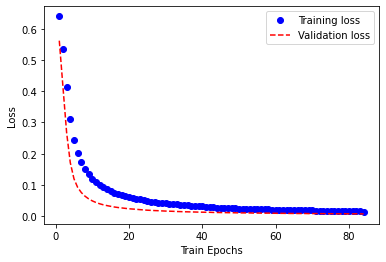

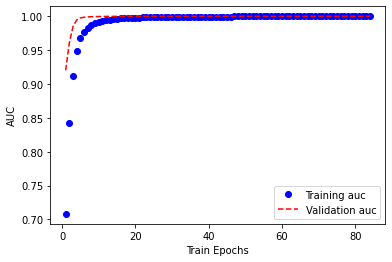

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

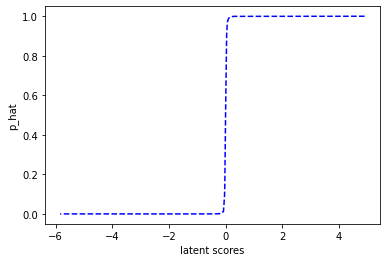

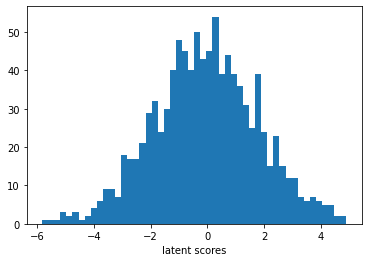

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

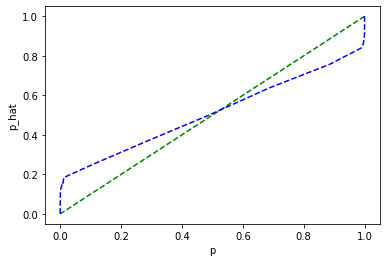

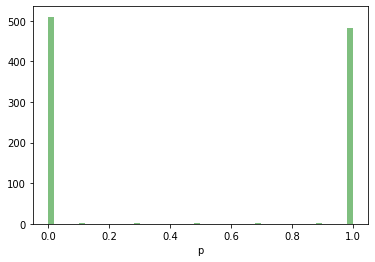

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

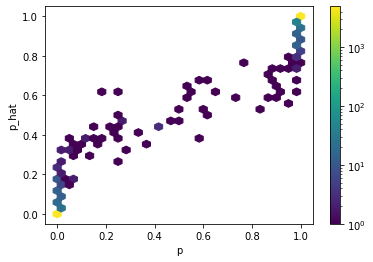

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

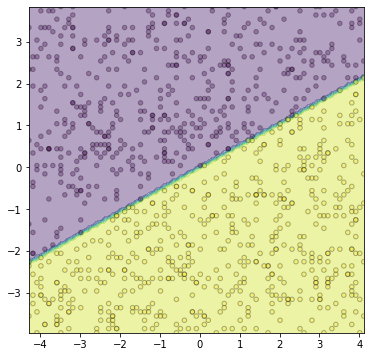

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 30)                330       
                                                                 
 dropout_72 (Dropout)        (None, 30)                0         
                                                                 
 dense_97 (Dense)            (None, 30)                930       
                                                                 
 dropout_73 (Dropout)        (None, 30)                0         
                                                                 
 dense_98 (Dense)            (None, 30)                930       
                                                                 
 dropout_74 (Dropout)        (None, 30)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.006,
 'batch': 256,
 'epoch': 59,
 'optimizer': 'sgd',
 'best_loss': {'loss': 0.0069915177300572395, 'epoch': 84},
 'best_auc': {'auc': 0.9999891519546509, 'epoch': 69},
 'best_accuracy': {'accuracy': 0.9983000159263611, 'epoch': 71},
 'model': <keras.engine.sequential.Sequential at 0x7f372575d160>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.03699065372347832, 'epoch': 41},
  'best_auc': {'auc': 0.9997425675392151, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9902999997138977, 'epoch': 40}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.026163799688220024, 'epoch': 41},
  'best_auc': {'auc': 0.9998794794082642, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9940500259399414, 'epoch': 41}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 28,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.022855497896671295, 'epoch': 41},
  'best_auc': {'auc': 0.9999233484268188, 'epoch': 41},
  'best_accuracy': {'accuracy': 0.9946500062942505, 'epoch': 40}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 59,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.00891751516610384, 'epoch': 84},
  'best_auc': {'auc': 0.9999901652336121, 'epoch': 84},
  'best_acc

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25